<a href="https://colab.research.google.com/github/abyanjan/Fine-Tune-BERT-for-Text-Classification/blob/master/Fine_tune_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FINE TUNIG BERT FOR TWITTER SENTIMENT CLASSIFICATION WITH HUGGING FACE TRANSFORMERS AND TENSORFLOW

### Read and Explore Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_df = pd.read_excel("/content/drive/My Drive/Train_Test_Data_checked_10000.xlsx")
#test_df = pd.read_csv('test.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_excel("D:\Transformer_project\FinalData2_4500.xlsx")

In [ ]:
# check the size of the data
print("Train data size \n", train_df.shape )
print()
#print("Test data size \n", test_df.shape )

Train data size 
 (10200, 4)



In [ ]:
# check data sample
train_df.head()

,text,clean_text,response,Target_Social
0,You'll dance on?,You ll dance on,No.,0
1,"you don't recharge your phone, your phone rech...",you don recharge your phone your phone recharg...,"No, the message is not asking a question to th...",0
2,RT @bebeinghuman: @myntra @myntra we promise t...,we promise to help you with your promise,"No, the message is not asking a question to th...",0
3,RT @SwiggyInstamart: Let our V-day cards guide...,Let our day cards guide your love life amp gui...,NaN,0
4,"They say "" Count your blessings"". _x000D__x000...",They say Count your blessings Us Thanks for Mi...,"No, the message is not asking a question or re...",0


In [ ]:
#test_df.head()

We see that for test data we do not have the 'target' columns. We will need to predict the target for the test data and submit to kaggle to check for our score.

So, for the rest of the part , we will be only working with the train data to train our model.

In [ ]:
# checking for any duplicates in the text columns
train_df['clean_text'].duplicated().sum()

462

In [ ]:
# dropping the duplicates
train_df = train_df.drop_duplicates('clean_text', keep='first')
train_df.shape
train_df.columns

Index(['ID', 'text', 'clean_text', 'real_label'], dtype='object')

<Axes: >

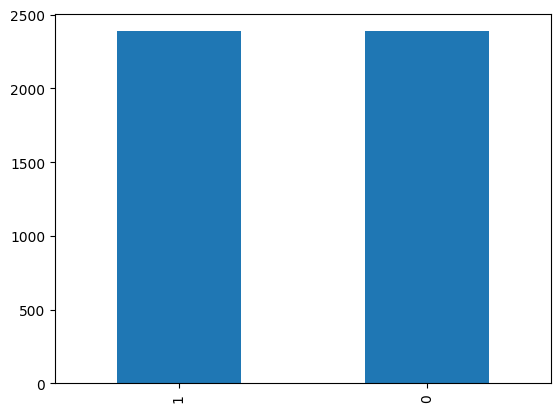

In [ ]:
# checking the target distribution
train_df.real_label.value_counts().plot(kind = 'bar')

In [ ]:
import pandas as pd

# Assuming 'real_label' is your target column
label_counts = train_df['real_label'].value_counts()
min_count = label_counts.min()

label1 = train_df[train_df['real_label']==1].copy().sample(min_count, random_state=1423)
label0 = train_df[train_df['real_label']==0].copy().sample(min_count, random_state=1423)

balanced_df = pd.concat([label1, label0], ignore_index=True)
shuffled_df = balanced_df.sample(frac=1, random_state=42)
shuffled_df.reset_index(drop=True, inplace=True)
train_df = shuffled_df


We see that there is a balanaced distribution of the target levels.

In [ ]:
# Exploring the text lengths
textlen = train_df['text'].apply(lambda x: len(x.split()))

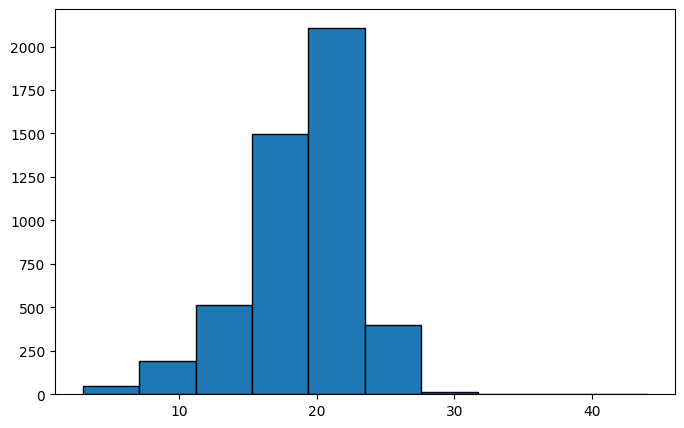

In [ ]:
# vsualize the text length
import seaborn as sns
plt.figure(figsize=(8,5))
plt.hist(textlen, edgecolor = "black");

We can set the maximum sequence length as 30, for training our bert model.

In [ ]:
SEQ_LEN = 35

^C
Note: you may need to restart the kernel to use updated packages.


### Fine Tuning BERT

In [ ]:
from transformers import BertTokenizer
from transformers import AutoTokenizer
import tensorflow as tf

In [ ]:
# download the tokenizer
#task = "sentiment"
#MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
#tokenizer = AutoTokenizer.from_pretrained(MODEL, do_lower_case = True)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Before tokenizing the text, we can do some text cleaning to remove the user name and any http links in the tweet text.

In [ ]:
# Preprocess text (username and link placeholders)
'''
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = t.replace("#","")
        new_text.append(t.lower())
    return " ".join(new_text).strip().replace("  ", " ")
    '''

In [ ]:
import string

def reList2(lst, lstNOT, sep):
    for y in lstNOT:
        lst = [x for x in lst if y not in x]
    return sep.join(lst)

def reList3(lst, lstYES, sep):
    return sep.join([x for x in lst if x in lstYES])

numLst = [str(num).zfill(2) for num in range(100)]

def preprocess(cell):
    cell = cell.lower()
    cell = reList2(cell.split(), ['http'] + numLst, ' ')
    cell = reList3(cell, string.ascii_letters + ' ,.?!";:' + "'", '')
    return cell

In [ ]:
train_df['text'] = train_df['text'].apply(preprocess)
train_df['real_label'] = train_df['real_label'].astype(int)
train_df.head(20)

,ID,text,clean_text,real_label
0,22073,are you ready for the lgaiconnect event? the c...,Are you ready for the event The countdown is o...,1
1,16318,win exclusive ice cream hamper! participate in...,WIN EXCLUSIVE ICE CREAM HAMPER Participate in ...,1
2,10290,"this summer season, reward yourself a short su...",This Summer Season reward yourself short summe...,1
3,16518,"icici allnew banking ka super instabiz, allow...",ICICI Bank all new Business Banking ka Super A...,1
4,20645,"as the match begins, are you ready to bag this...",As the th Match begins are you ready to bag th...,1
5,30332,"make your mood your style, or style your mood,...",Make your mood your style or style your mood w...,0
6,28623,"in your journey of life, how many saplings hav...",In your journey of life how many saplings have...,1
7,25545,guess currently crying leg day hai yaaarrr,Guess somebody currently crying aaj leg day ha...,1
8,27734,still haven't taken a sefie with rishabh? do i...,Still haven taken sefie with Rishabh Do it tod...,1
9,33987,rt pruchisoya: daily practice of vakrasana and...,Daily practice of Vakrasana and adding honey i...,0


**Encoding the text for Bert model**

In [ ]:
# example of tokenization
tokenizer.tokenize(preprocess("Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"))

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 'earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all']

In [ ]:
# example of an output from encoded text by tokeneizer
encoded_input = tokenizer(preprocess("shrihan, hi"))
print(encoded_input)

{'input_ids': [101, 14880, 4819, 1010, 7632, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [ ]:
tokenizer.decode(encoded_input['input_ids'])

'[CLS] shrihan, hi [SEP]'

In [ ]:
trainList = train_df['clean_text'].astype(str).tolist()

In [ ]:
# encoding the training data
train_encoded_inputs = tokenizer(trainList,
                                 add_special_tokens=True,
                                 padding='max_length',
                                 truncation=True,
                                 max_length=SEQ_LEN,
                                 return_tensors='tf',
                                 return_token_type_ids=False,
                                 return_attention_mask=True)



In [ ]:
train_encoded_inputs

{'input_ids': <tf.Tensor: shape=(1472, 35), dtype=int32, numpy=
array([[ 101, 6631, 1996, ...,    0,    0,    0],
       [ 101, 5049, 9453, ...,    0,    0,    0],
       [ 101, 2122, 4107, ...,    0,    0,    0],
       ...,
       [ 101, 2256, 4506, ...,    0,    0,    0],
       [ 101, 2108, 1996, ...,    0,    0,    0],
       [ 101, 1996, 2047, ...,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1472, 35), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
# formatting the data as required by bert model
def map_bert(inputs, labels):
  inputs = {'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']}

  return inputs, labels

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=1234, stratify=train_df['real_label'])

train_encoded_inputs = tokenizer(train_df['text'].tolist(),
                                 add_special_tokens=True,
                                 padding='max_length',
                                 truncation=True,
                                 max_length=SEQ_LEN,
                                 return_tensors='tf',
                                 return_token_type_ids=False,
                                 return_attention_mask=True)

val_encoded_inputs = tokenizer(val_df['text'].tolist(),
                               add_special_tokens=True,
                               padding='max_length',
                               truncation=True,
                               max_length=SEQ_LEN,
                               return_tensors='tf',
                               return_token_type_ids=False,
                               return_attention_mask=True)

train_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_encoded_inputs['input_ids'],
    'attention_mask': train_encoded_inputs['attention_mask']
}, train_df['real_label'].values))

val_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': val_encoded_inputs['input_ids'],
    'attention_mask': val_encoded_inputs['attention_mask']
}, val_df['real_label'].values))

train_dataset = train_dataset.map(map_bert)
val_dataset = val_dataset.map(map_bert)

train_ds = train_dataset.shuffle(100000).batch(64)
val_ds = val_dataset.batch(64)

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(30,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(30,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int64, name=None))>

**Creating Tensorflow data**

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_encoded_inputs, train_df['real_label'].values))

In [ ]:
train_dataset = train_dataset.map(map_bert)

In [ ]:
for t in train_dataset.take(2):
  print (t)

({'input_ids': <tf.Tensor: shape=(35,), dtype=int32, numpy=
array([ 101, 2017, 2222, 3153, 2006,  102,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(35,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
({'input_ids': <tf.Tensor: shape=(35,), dtype=int32, numpy=
array([  101,  2017,  2123, 28667,  8167,  3351,  2115,  3042,  2115,
        3042, 28667,  8167,  8449,  2017,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(35,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1,

**Creating train and test split**

In [ ]:
dataset = train_dataset.shuffle(100000).batch(64)

In [ ]:
# length of the dataset(total batches)
DS_LEN = len(dataset)
DS_LEN

23

In [ ]:
# take 80% for train and 20% for validation
SPLIT = 0.8
train_ds = dataset.take(round(DS_LEN*SPLIT))
val_ds = dataset.skip(round(DS_LEN*SPLIT))

**Modeling**

In [ ]:
from transformers import TFAutoModel

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# create model architecture
#n_classes = len((train_df.target.unique()))

# Input layers
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name='input_ids' )
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name = 'attention_mask')

# bert embeddings
embeddings = bert([input_ids, mask])[0]
embeddings = tf.keras.layers.BatchNormalization()(embeddings)
cls_token = embeddings[:,0,:]

cls_token = tf.keras.layers.BatchNormalization()(cls_token)

'''
num_layers = 6
bert_layers = []

for layer_num in range(num_layers):
    # Attention Sub-Layer
    attention_output = tf.keras.layers.Attention()([cls_token, cls_token, cls_token])

    # Feedforward Sub-Layer
    feedforward_output = tf.keras.layers.Dense(units=768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention_output)
    dropout_output = tf.keras.layers.BatchNormalization()(feedforward_output)
    dropout_output = tf.keras.layers.Dropout(0.5)(dropout_output)

    bert_layers.append(dropout_output)

# Concatenate all output from attention layers
attention_outputs = tf.keras.layers.Concatenate()(bert_layers)
'''


# Additional Dense Layers for Task-Specific Information
dense_layer_1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(cls_token)
embeddings = tf.keras.layers.BatchNormalization()(dense_layer_1)
dense_layer_1 = tf.keras.layers.Dropout(0.5)(dense_layer_1)

dense_layer_2 = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense_layer_1)
embeddings = tf.keras.layers.BatchNormalization()(dense_layer_2)
dense_layer_2 = tf.keras.layers.Dropout(0.5)(dense_layer_2)

reshaped_output = tf.keras.layers.Reshape((-1, 64))(dense_layer_2)
pooled_output = tf.keras.layers.GlobalAveragePooling1D()(reshaped_output)

# Output layer
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(pooled_output)

# Create model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=output_layer)

In [ ]:
# freezing the pretrained bert layer
model.layers[2].trainable = False
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 35)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 35)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 35, 76                                    

**Compile model**

In [ ]:
import transformers
import os

In [ ]:
#learning_rate = 1e-3

#optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
optimizer = transformers.AdamWeightDecay(learning_rate=5e-4)
#optimizer = tf.keras.optimizers.SGD(learning_rate=5e-4)
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.BinaryAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
del history

In [ ]:
model.predict(val_ds)

In [ ]:
# train the model
import pickle
import json

filepathBestmodel = '/content/drive/MyDrive/best_model4.hdf5'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepathBestmodel,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1,min_delta=0.001,monitor='val_loss'), tf.keras.callbacks.EarlyStopping(patience=20, min_delta=0.001, monitor='val_loss')]

#tf.keras.callbacks.EarlyStopping(patience=20, min_delta=0.001, monitor='val_loss')


history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    callbacks = callbacks + [checkpoint_callback]
)

with open('/content/drive/MyDrive/training_history4.json', 'w') as file:
    json.dump(str(history.history), file)
model.load_weights(filepathBestmodel)

Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 1.1963 - accuracy: 0.5873
Epoch 1: val_loss improved from inf to 0.92550, saving model to /content/drive/MyDrive/best_model4.hdf5
48/48 [==============================] - 26s 294ms/step - loss: 1.1963 - accuracy: 0.5873 - val_loss: 0.9255 - val_accuracy: 0.6610 - lr: 5.0000e-04
Epoch 2/100
48/48 [==============================] - ETA: 0s - loss: 1.0309 - accuracy: 0.6361
Epoch 2: val_loss improved from 0.92550 to 0.89363, saving model to /content/drive/MyDrive/best_model4.hdf5
48/48 [==============================] - 11s 234ms/step - loss: 1.0309 - accuracy: 0.6361 - val_loss: 0.8936 - val_accuracy: 0.7029 - lr: 5.0000e-04
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 0.9780 - accuracy: 0.6469
Epoch 3: val_loss improved from 0.89363 to 0.87085, saving model to /content/drive/MyDrive/best_model4.hdf5
48/48 [==============================] - 12s 256ms/step - loss: 0.9780 - accuracy: 0.6469 - val_l

In [ ]:
from tensorflow.keras.models import Sequential, load_model
filepathBestmodel = '/content/drive/MyDrive/best_model4.hdf5'
model.load_weights(filepathBestmodel)
with open('/content/drive/MyDrive/training_history4.json', 'r') as file:
    historyStr = json.load(file)
corrected_str = historyStr.replace("{'", '{"').replace("':", '":').replace(", '", ', "').replace("'}", '"}')
history = json.loads(corrected_str)

Best model :
Maximum accuracy achieved = 0.7664921283721924
Minimum loss achieved = 0.6172651052474976


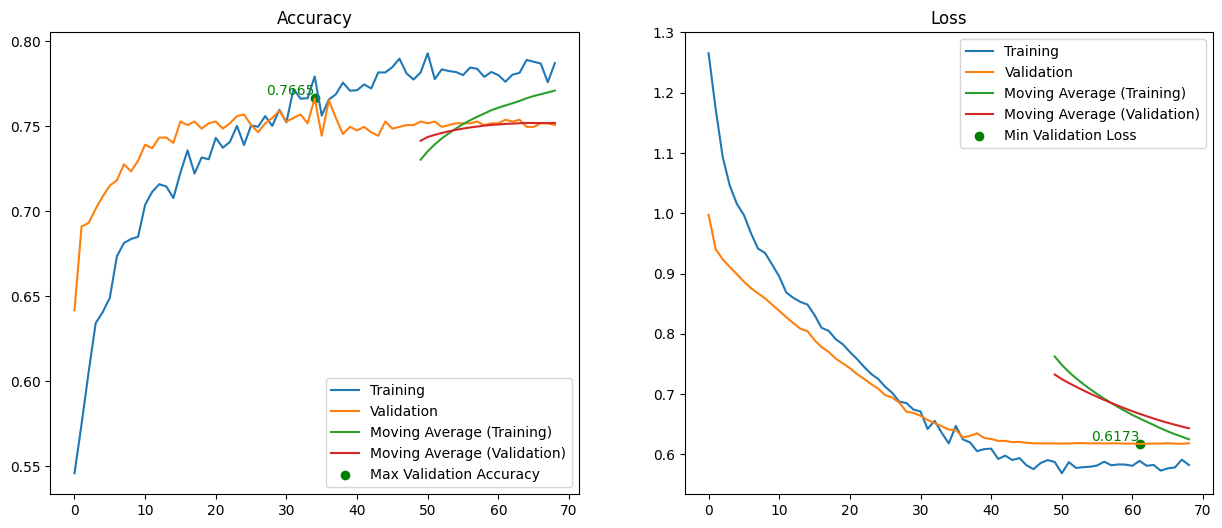

30/30 [==============================] - 7s 93ms/step


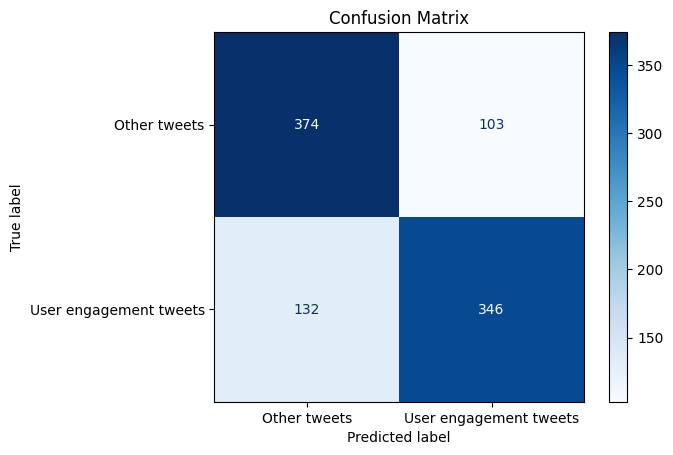

In [ ]:
print(f"Best model :\nMaximum accuracy achieved = {max(history['val_accuracy'])}\nMinimum loss achieved = {min(history['val_loss'])}")


import pandas as pd

# Convert the history dictionary to a Pandas DataFrame for easier manipulation
history_df = pd.DataFrame(history)

# Set the window size for the moving averages
window_size = 50  # You can adjust this value based on your preference

# Calculate moving averages for accuracy and loss
history_df['ma_accuracy'] = history_df['accuracy'].rolling(window=window_size).mean()
history_df['ma_val_accuracy'] = history_df['val_accuracy'].rolling(window=window_size).mean()
history_df['ma_loss'] = history_df['loss'].rolling(window=window_size).mean()
history_df['ma_val_loss'] = history_df['val_loss'].rolling(window=window_size).mean()

# Plot the performance curve with moving averages
epochs = range(len(history_df))

plt.figure(figsize=(15, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history_df['accuracy'], label="Training")
plt.plot(epochs, history_df['val_accuracy'], label="Validation")
plt.plot(epochs, history_df['ma_accuracy'], label="Moving Average (Training)")
plt.plot(epochs, history_df['ma_val_accuracy'], label="Moving Average (Validation)")
max_val_accuracy_epoch = np.argmax(history_df['val_accuracy'])
plt.scatter(max_val_accuracy_epoch, history_df['val_accuracy'][max_val_accuracy_epoch], color='green', label='Max Validation Accuracy')
plt.text(max_val_accuracy_epoch, history_df['val_accuracy'][max_val_accuracy_epoch], f'{history_df["val_accuracy"][max_val_accuracy_epoch]:.4f}', color='green', ha='right', va='bottom')
plt.legend()
plt.title("Accuracy")

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history_df['loss'], label="Training")
plt.plot(epochs, history_df['val_loss'], label="Validation")
plt.plot(epochs, history_df['ma_loss'], label="Moving Average (Training)")
plt.plot(epochs, history_df['ma_val_loss'], label="Moving Average (Validation)")
min_val_loss_epoch = np.argmin(history_df['val_loss'])
plt.scatter(min_val_loss_epoch, history_df['val_loss'][min_val_loss_epoch], color='green', label='Min Validation Loss')
plt.text(min_val_loss_epoch, history_df['val_loss'][min_val_loss_epoch], f'{history_df["val_loss"][min_val_loss_epoch]:.4f}', color='green', ha='right', va='bottom')
plt.legend()
plt.title("Loss")

plt.show()



# evaluate on val data
model.evaluate(val_ds)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Making predictions on the validation dataset
y_pred_probs = model.predict(val_ds)
y_pred = (y_pred_probs > 0.5).astype(int)

# Getting the actual labels from the validation dataset
y_true = [label for _, label in val_ds.unbatch()]

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Other tweets', 'User engagement tweets'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


### Make prediction for test data

In [ ]:
test_df = train_df.loc[666:,:]

In [ ]:
# clean text
test_df['text'] = test_df['text'].apply(preprocess)

In [ ]:
# encoding the test data
test_encoded_inputs = tokenizer(test_df['clean_text'].astype(str).tolist(),
                                 add_special_tokens = True,
                                 padding='max_length',
                                 truncation=True,
                                 max_length=SEQ_LEN,
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')

In [ ]:
# create tf dataset
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encoded_inputs))


In [ ]:
test_dataset

<_TensorSliceDataset element_spec={'input_ids': TensorSpec(shape=(30,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(30,), dtype=tf.int32, name=None)}>

In [ ]:
for d in train_dataset.take(1):
  print (d)

({'input_ids': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([ 101, 3153,  102,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [ ]:
# make prediction
test_ds = test_dataset.shuffle(100000).batch(64)
test_pred = model.predict(test_ds)

6/6 [==============================] - 4s 131ms/step


In [ ]:
test_pred

array([[0.19339481],
       [0.07908394],
       [0.20727545],
       [0.19510122],
       [0.16868645],
       [0.0844283 ],
       [0.05552678],
       [0.09417947],
       [0.16664411],
       [0.16596113],
       [0.07660527],
       [0.2104581 ],
       [0.324963  ],
       [0.25106502],
       [0.075561  ],
       [0.28298587],
       [0.38734287],
       [0.2544269 ],
       [0.42486185],
       [0.17446093],
       [0.14883839],
       [0.23418759],
       [0.08467299],
       [0.28376278],
       [0.509487  ],
       [0.544184  ],
       [0.33848906],
       [0.23801115],
       [0.18830842],
       [0.59416467],
       [0.68190277],
       [0.3887638 ],
       [0.21424542],
       [0.26137048],
       [0.41131958],
       [0.29725316],
       [0.05104017],
       [0.20547783],
       [0.19450632],
       [0.16312085],
       [0.7590869 ],
       [0.1306406 ],
       [0.14827454],
       [0.13205479],
       [0.11665823],
       [0.42198908],
       [0.1733692 ],
       [0.182

In [ ]:
test_pred.shape

(335, 1)

In [ ]:
# create the target labels for test data
test_target = np.round(test_pred).flatten()
test_target

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
test_target.shape

(335,)

In [ ]:
test_df['target'] = test_target.astype('int')
test_df.head(10)

<ipython-input-58-7b3cfb12cc86>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'] = test_target.astype('int')


,ID,text,retweet_count,favorite_count,Content_type,Service,clean_text,response,Target_Social,target
666,40479,"When was the ""nxt"" app launched to make bankin...",151.00000,314.0,photo,1,nxt app launched make banking accessible share...,Yes\n\nThe message is asking the reader when t...,1,0
667,25439,"Next time you gotta tell them ""kapde chhote na...",0.00001,19.0,Text,0,next time gotta tell kapde chhote nahi apki so...,No. The message is not asking a question to th...,0,0
668,25436,"Life is too short to argue, just say this and ...",6.00000,18.0,Text,0,life short argue say move,No. This message is not asking a question to t...,0,0
669,31616,Cardless cash withdrawal - Not the simplicity ...,17.00000,54.0,photo,1,cardless cash withdrawal simplicity need simpl...,No\n\nThe message is not asking a question to ...,0,0
670,13446,"Remember - Roz khao Ande?_x000D__x000D_\nYes, ...",0.00001,5.0,photo,1,remember roz khao yes eggs important getting f...,No. The message is not asking a question to th...,0,0
671,14136,It is in Hero FinCorp's best interest to suppo...,1.00000,4.0,photo,1,hero fincorps best interest support financial ...,No. This message is not asking a question to t...,0,0
672,15649,Being a Hyundai customer is now more exciting ...,4.00000,19.0,video,0,hyundai customer exciting ever shop away favou...,No. This message is not asking a question to t...,0,0
673,9972,Next question is about your favourite thing in...,43.00000,98.0,Text,1,next question favourite thing summer guessed r...,Yes. The message is asking the reader a questi...,1,0
674,7353,Let us raise awareness of the many dangers ill...,10.00000,59.0,photo,1,let us raise awareness many dangers illicit dr...,No. This message is not asking a question to t...,0,0
675,28546,Your go-to snack for movie marathons is_____._...,0.00001,4.0,Text,0,goto snack movie marathons,No. This message is not asking a question to t...,0,0


In [ ]:
test_df.tail(6)

,ID,text,retweet_count,favorite_count,Content_type,Service,clean_text,response,Target_Social,target
995,12904,It was in 2015 when we piloted EMBED (Eliminat...,0.00001,5.00000,photo,0,piloted embed elimination mosquito borne endem...,No. This message is not asking a question to t...,0,0
996,15681,RT @arpitmahendra3: Check out the new tail lam...,0.00001,0.00001,Text,0,check new tail lamp runs across width car cluster,No. This message is not asking a question to t...,0,0
997,15692,RT @manav_sinha: In Hyderabad to drive the new...,0.00001,0.00001,Text,0,hyderabad drive new facelift gets big changes ...,No. The message is not asking a question or re...,0,0
998,5586,Waiting for so long for Higher Interest Rate e...,25.00000,76.00000,photo,1,waiting long higher interest rate ends bank in...,No. This message is not asking a question to t...,0,0
999,13807,It's true!_x000D__x000D_\n_x000D__x000D_\nIt's...,4.00000,31.00000,video,1,possible complete loan process get amount disb...,No. This message is not asking a question to t...,0,0
1000,15658,RT @deepaliranaa: What is 2 step rear reclinin...,0.00001,0.00001,Text,0,step rear reclining seat feature new hyundai v...,No\n\nThis message is not asking a question to...,0,0
